In [1]:
import pystac
import pystac_client
import boto3
import icechunk
import zarr
import xarray as xr
import os
import numpy as np
import shapely
from shapely import wkt
from shapely.geometry import box
import warnings
from datetime import datetime, timezone, timedelta
from obstore.store import S3Store
from virtualizarr import open_virtual_dataset
from virtualizarr.registry import ObjectStoreRegistry
from virtual_tiff import VirtualTIFF
from obstore.auth.boto3 import Boto3CredentialProvider
from rasterio.warp import transform_bounds
from zarr.dtype import VariableLengthUTF8
from zarr_datafusion_search import ZarrTable
from datafusion import SessionContext
import pyproj
import xproj
import rasterix
import logging
import morecantile
from shapely.ops import transform
from pyproj import Transformer
from affine import Affine
from rasterix import RasterIndex
import folium
from rasterio.transform import array_bounds
from pyresample.area_config import create_area_def
from pyresample.gradient import block_nn_interpolator, gradient_resampler_indices_block
from pyresample.resampler import resample_blocks

In [2]:
warnings.filterwarnings("ignore")
xr.set_options(display_expand_indexes=True)

#### Select a Landsat granule from the Earth-Search STAC API

In [3]:
catalog = pystac_client.Client.open("https://earth-search.aws.element84.com/v1")

california_bbox = [-124.4096, 32.5343, -114.1312, 42.0095]

search = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=california_bbox,
    datetime="2025-10-01/2025-10-10",
    max_items=10
)

items = list(search.items())
item = items[4]
item

<Item id=LC09_L2SP_038038_20251008_02_T1>

#### Set protocol, bucket and AWS profile values for use in obstore, virtualizarr registry and Icechunk virtual chunk container.

In [4]:
scheme = "s3://"
bucket = "usgs-landsat"
region = "us-west-2"

In [5]:
profile = "impactnew"
os.environ["AWS_PROFILE"] = profile

#### Configure obstore for requester pays access to the usgs-landsat bucket using the profile's credentials in order to parse COGs.

In [6]:
session = boto3.Session()
object_store = S3Store(
    bucket=bucket,
    region=region,
    request_payer=True,
    credential_provider=Boto3CredentialProvider(session=session),
)
registry = ObjectStoreRegistry({f"{scheme}{bucket}": object_store})

#### Configure a local icechunk store with a virtual chunk container which can access the usgs-landsat bucket with the profile's credentials.
#### Note that requester-pays support for virtual chunk containers in icechunk is still experimental and requires a PR based build.

In [7]:
location = "data/icechunk"
storage = icechunk.local_filesystem_storage(location)

config = icechunk.RepositoryConfig.default()
s3_chunk_store = icechunk.s3_store(
    region=region,
    requester_pays=True,
)
config.set_virtual_chunk_container(
    icechunk.VirtualChunkContainer(f"{scheme}{bucket}/", s3_chunk_store)
)
credentials = icechunk.containers_credentials(
    {f"{scheme}{bucket}/": icechunk.s3_credentials(from_env=True)}
)
repo = icechunk.Repository.open_or_create(
    storage=storage, config=config, authorize_virtual_chunk_access=credentials
)
session = repo.writable_session("main")

  2025-11-18T01:00:04.161694Z  WARN icechunk::storage::object_store: The LocalFileSystem storage is not safe for concurrent commits. If more than one thread/process will attempt to commit at the same time, prefer using object stores.
    at icechunk/src/storage/object_store.rs:80



#### Hardcode the number of overviews/IFDs to utilize for each asset.

In [8]:
overviews = 7

#### Write the zarr-datafusion-search metadata schema using a set of 1-d arrays.

In [9]:
def write_metadata_schema():
    root = zarr.open_group(session.store, mode="w", zarr_format=3)
    meta = root.create_group("meta")
    meta.create_array(
        "date",
        shape=(0,),
        dtype="datetime64[ms]",
    )
    meta.create_array(
        "bbox",
        shape=(0,),
        dtype=VariableLengthUTF8(),
    )
    meta.create_array(
        "group_path",
        shape=(0,),
        dtype=VariableLengthUTF8(),
    )

#### Use the STAC item to write zarr-datafusion-search metadata values for the item.

In [10]:
def write_item_metadata(item: pystac.Item):
    dt = zarr.open(
        store=session.store,
        path="/meta/date",
        mode="a"
    )
    dt.append(np.array([item.datetime], dtype="datetime64[ms]"))

    bbox_wkt = shapely.to_wkt(shapely.box(*item.bbox))
    bbox = zarr.open(
        store=session.store,
        path="/meta/bbox",
        mode="a"
    )
    bbox.append(np.array([bbox_wkt]))

    group_path = zarr.open(
        store=session.store,
        path="/meta/group_path",
        mode="a"
    )
    group_path.append(np.array([f"/{item.id}"])) 

#### Generate Zarr multiscales convetion metadata for the known overviews/IFDs in a Landsat COG.

In [11]:
def generate_multiscales(overviews: int):
    layout = list()
    for overview in range(overviews):
        if overview == 0:
            config = {
                "group": str(overview)
            }
        else:
            factor = 2
            scale = float(factor * overview)
            config = {
                "group": str(overview),
                "from_group": str(overview - 1),
                "factors": [factor, factor],
                "scale": [scale, scale],
                "translation": [0.0, 0.0],
                "resampling_method": "average"
            }
        layout.append(config)
                
    multiscales_extension = {
        "version": "0.1.0",
        "schema": "https://raw.githubusercontent.com/zarr-experimental/multiscales/refs/tags/v0.1.0/schema.json",
        "name": "Multiscales Attribute Extension",
        "description": "Geospatial power-of-2 pyramid composed with geo:proj for coordinate reference system",
        "spec": "https://github.com/zarr-experimental/multiscales/blob/v0.1.0/README.md",
        "configuration": {
            "version": "0.1.0",
            "layout": layout,
            "resampling_method": "average"
        }
    }
    return multiscales_extension

#### Use the STAC item's proj extension metadata to create Zarr geo-proj convention metadata.

In [12]:
def generate_geoproj(item: pystac.Item):
    projected_bbox = transform_bounds(
        "EPSG:4326",
        item.properties["proj:code"],
        *item.bbox
    )
    geo_proj_extension = {
        "version": "0.1.0",
        "schema": "https://raw.githubusercontent.com/zarr-experimental/geo-proj/refs/tags/v0.1.0/schema.json",
        "name": "geo:proj",
        "description": "Coordinate reference system information for geospatial data",
        "spec": "https://github.com/zarr-experimental/geo-proj/blob/v0.1.0/README.md",
        "configuration": {
            "code": item.properties["proj:code"],
            "spatial_dimensions": ["y", "x"],
            "transform": item.properties["proj:transform"],
            "shape": item.properties["proj:shape"],
            "bbox": projected_bbox,
        }
    }
    return geo_proj_extension

#### Parse the selected asset using Virtualizarr and write the resulting ManifestArray to Icechunk.

In [13]:
def write_item_data(item: pystac.Item, overviews: int):
    #assets = {asset_key: asset for asset_key, asset in item.assets.items() if asset.media_type == "image/tiff; application=geotiff; profile=cloud-optimized"}
    for key in ["red"]:
        asset = item.assets[key]
        for overview in range(overviews):
            group = f"{item.id}/{key}/multiscales/{overview}"
            ds = open_virtual_dataset(
                url=asset.href,
                registry=registry,
                parser=VirtualTIFF(ifd=overview)
            )
            ds.vz.to_icechunk(
                store=session.store,
                group=group,
            )        

#### Write the Zarr conventions to their defined UUID keys.

In [14]:
geo_proj_uuid = "f17cb550-5864-4468-aeb7-f3180cfb622f"
multiscales_uuid = "d35379db-88df-4056-af3a-620245f8e347"
def write_item_conventions(item: pystac.Item, overviews: int):
    item_group = zarr.open_group(session.store, path=f"/{item.id}", zarr_format=3)
    multiscales_convention = generate_multiscales(overviews)
    geo_proj_convention = generate_geoproj(item)
    item_group.attrs[multiscales_uuid] = multiscales_convention
    item_group.attrs[geo_proj_uuid] = geo_proj_convention

In [15]:
write_metadata_schema()
write_item_metadata(item=item)
write_item_data(item=item, overviews=overviews)
write_item_conventions(item=item, overviews=overviews)
session.commit("First")

'5P44TSBQY6CXDFSCKKN0'

In [16]:
store = zarr.open(session.store)
store.tree()

/
├── LC09_L2SP_038038_20251008_02_T1
│   └── red
│       └── multiscales
│           ├── 0
│           │   └── 0 (7691, 7561) uint16
│           ├── 1
│           │   └── 1 (3846, 3781) uint16
│           ├── 2
│           │   └── 2 (1923, 1891) uint16
│           ├── 3
│           │   └── 3 (962, 946) uint16
│           ├── 4
│           │   └── 4 (481, 473) uint16
│           ├── 5
│           │   └── 5 (241, 237) uint16
│           └── 6
│               └── 6 (121, 119) uint16
└── meta
    ├── bbox (1,) StringDType()
    ├── date (1,) datetime64
    └── group_path (1,) StringDType()

#### Use zarr-datafusion-search to select members of the data collection with simple SQL that can use any "column" in the metadata schema.

In [17]:
zarr_table = await ZarrTable.from_icechunk(session=session, group_path="/meta")
ctx = SessionContext()
ctx.register_table_provider("icechunk_data", zarr_table)
sql = "SELECT * FROM icechunk_data WHERE date < CAST('2025-10-10' AS DATE);"
df = ctx.sql(sql)
df.show()

DataFrame()
+-------------------------------------------------------------------------------------------------------------------------------+-------------------------+----------------------------------+
| bbox                                                                                                                          | date                    | group_path                       |
+-------------------------------------------------------------------------------------------------------------------------------+-------------------------+----------------------------------+
| POLYGON ((-113.249903 30.670595, -113.249903 32.794705, -115.693929 32.794705, -115.693929 30.670595, -113.249903 30.670595)) | 2025-10-08T18:10:55.608 | /LC09_L2SP_038038_20251008_02_T1 |
+-------------------------------------------------------------------------------------------------------------------------------+-------------------------+----------------------------------+


[src/table.rs:41:9] "Created icechunk session from msgpack serialization" = "Created icechunk session from msgpack serialization"
[src/table.rs:42:9] icechunk_session.config() = RepositoryConfig {
    inline_chunk_threshold_bytes: None,
    get_partial_values_concurrency: None,
    compression: None,
    max_concurrent_requests: None,
    caching: None,
    storage: None,
    virtual_chunk_containers: Some(
        {
            "s3://usgs-landsat/": VirtualChunkContainer {
                name: None,
                url_prefix: "s3://usgs-landsat/",
                store: S3(
                    S3Options {
                        region: Some(
                            "us-west-2",
                        ),
                        endpoint_url: None,
                        anonymous: false,
                        allow_http: false,
                        force_path_style: false,
                        network_stream_timeout_seconds: Some(
                            60,
      

#### Select the first row returned by the zarr-datafusion-search query and get the Zarr group path for the granule it describes.

In [18]:
first_row = df.to_arrow_table().to_pylist()[0]
item_group = zarr.open_group(session.store, path=first_row["group_path"], mode="r")
item_group_attrs = dict(item_group.attrs)
geo_proj = item_group_attrs[geo_proj_uuid]
multiscales = item_group_attrs[multiscales_uuid]

#### Open the lowest level overview as an xarray dataset.

In [19]:
ds = xr.open_zarr(store=session.store, group=f"{first_row['group_path']}/red/multiscales/0")
ds

<xarray.Dataset> Size: 116MB
Dimensions:  (y: 7691, x: 7561)
Dimensions without coordinates: y, x
Data variables:
    0        (y, x) uint16 116MB dask.array<chunksize=(256, 256), meta=np.ndarray>

#### Use the geo-proj convention metadata to create an affine transformation and set a rasterix RasterIndex to use for selection operations.

In [20]:
affine = Affine(*geo_proj["configuration"]["transform"])
index = RasterIndex.from_transform(
    affine=affine,
    width=geo_proj["configuration"]["shape"][1],
    height=geo_proj["configuration"]["shape"][0],
    x_dim="x",
    y_dim="y",
    crs=geo_proj["configuration"]["code"],
)
coords = xr.Coordinates.from_xindex(index)
ds = ds.assign_coords(coords)
ds

<xarray.Dataset> Size: 116MB
Dimensions:  (y: 7691, x: 7561)
Coordinates:
  * y        (y) float64 62kB 3.629e+06 3.629e+06 ... 3.399e+06 3.399e+06
  * x        (x) float64 60kB 6.249e+05 6.249e+05 ... 8.517e+05 8.517e+05
Data variables:
    0        (y, x) uint16 116MB dask.array<chunksize=(256, 256), meta=np.ndarray>
Indexes:
  ┌ x        RasterIndex (crs=EPSG:32611)
  └ y

#### Use the geo-proj convention metadata to assign the appropriate CRS via xproj.
#### rasterix and xproj are not explictly need for this example but will become more useful with multi-CRS examples.

In [21]:
ds = ds.proj.assign_crs(spatial_ref=geo_proj["configuration"]["code"], allow_override=True)
ds

<xarray.Dataset> Size: 116MB
Dimensions:      (y: 7691, x: 7561)
Coordinates:
  * y            (y) float64 62kB 3.629e+06 3.629e+06 ... 3.399e+06 3.399e+06
  * x            (x) float64 60kB 6.249e+05 6.249e+05 ... 8.517e+05 8.517e+05
  * spatial_ref  int64 8B 0
Data variables:
    0            (y, x) uint16 116MB dask.array<chunksize=(256, 256), meta=np.ndarray>
Indexes:
  ┌ x            RasterIndex (crs=EPSG:32611)
  └ y
    spatial_ref  CRSIndex (crs=EPSG:32611)

#### Get the list of web merctaor tiles intersecting the granule.

In [22]:
granule_bbox = morecantile.commons.BoundingBox(*item.bbox)
tms = morecantile.tms.get("WebMercatorQuad")
tiles = list(tms.tiles(*granule_bbox, zooms=12))

#### Select one of the intersecting tiles and reproject its bounds to the granule's CRS.

In [23]:
tile_bbox = tms.xy_bounds(tiles[700])
tile_bbox_geom = shapely.geometry.box(*tile_bbox)
utm_transformer = Transformer.from_crs("EPSG:3857", item.properties["proj:code"], always_xy=True).transform
tile_bbox_utm = transform(utm_transformer, tile_bbox_geom)
tile_bbox_utm.bounds

(652633.3340567892, 3428218.1529057985, 661147.6439239838, 3436691.743682587)

#### We can use this reprojected tile bbox for CRS aware selection operations in xarray with rasterix.¶

In [24]:
left, bottom, right, top = tile_bbox_utm.bounds
ds_tile = ds.sel(x=slice(left, right), y=slice(top, bottom))
ds_tile

<xarray.Dataset> Size: 165kB
Dimensions:      (y: 282, x: 284)
Coordinates:
  * y            (y) float64 2kB 3.437e+06 3.437e+06 ... 3.428e+06 3.428e+06
  * x            (x) float64 2kB 6.526e+05 6.526e+05 ... 6.611e+05 6.611e+05
  * spatial_ref  int64 8B 0
Data variables:
    0            (y, x) uint16 160kB dask.array<chunksize=(232, 100), meta=np.ndarray>
Indexes:
  ┌ x            RasterIndex (crs=EPSG:32611)
  └ y
    spatial_ref  CRSIndex (crs=EPSG:32611)

#### For context, display a map to visualize the web mercator tiles that intersect the granule.

In [25]:
zoom_bbox = box(*item.bbox)
zoom_bbox.centroid
m = folium.Map(
    location=[zoom_bbox.centroid.y, zoom_bbox.centroid.x],
    zoom_start=8,
    tiles="CartoDB positron",
    width="50%",
)
folium.Rectangle(
    bounds=[
        [item.bbox[1], item.bbox[0]],  # [south, west]
        [item.bbox[3], item.bbox[2]]   # [north, east]
    ],
    color="red",
    fill=True,
    fillOpacity=0.1,
    weight=3,
).add_to(m)
for tile in tiles:
    tile_bounds = tms.bounds(tile)
    
    folium.Rectangle(
        bounds=[
            [tile_bounds.bottom, tile_bounds.left],   # southwest
            [tile_bounds.top, tile_bounds.right]      # northeast
        ],
        color='blue',
        fill=True,
        fillOpacity=0.1,
        weight=0.5,
        popup=f"Tile: {tile.z}/{tile.x}/{tile.y}"
    ).add_to(m)
m

#### Using the geo-proj metadata configure a pyresample source area definition for granule and a target area definition for the selected tile.

In [26]:
tile_shape = 256
height, width = geo_proj["configuration"]["shape"]
left, bottom, right, top = array_bounds(height, width, affine)
target_area_def = create_area_def(
    area_id=1,
    projection="EPSG:3857",
    shape=(tile_shape, tile_shape),
    area_extent=tile_bbox_geom.bounds
)

source_area_def = create_area_def(
    area_id=2,
    projection=geo_proj["configuration"]["code"],
    shape=(geo_proj["configuration"]["shape"][0], geo_proj["configuration"]["shape"][1]),
    area_extent=geo_proj["configuration"]["bbox"],
)

#### Set the dataarray chunking to reflect the web optimized profile used by the Landsat COGs.
#### Use pyresample to resample blockwise from the granule's CRS to web mercator.

In [27]:
da = ds["0"]
indices_xy = resample_blocks(
    gradient_resampler_indices_block,
    source_area_def,
    [],
    target_area_def,
    chunk_size=(tile_shape),
    dtype=float,
)
resampled = resample_blocks(
    block_nn_interpolator,
    source_area_def,
    [da.data],
    target_area_def,
    dst_arrays=[indices_xy],
    chunk_size=(tile_shape),
    dtype=da.dtype,
)
projected_tile = resampled.compute()

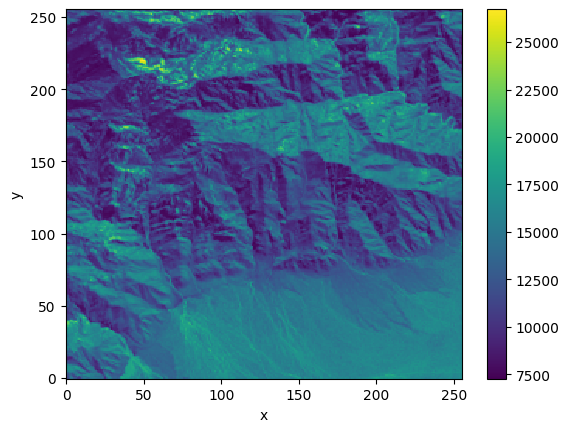

In [28]:
wmts_tile = xr.DataArray(projected_tile, dims=("y", "x"))
wmts_tile.plot()

#### Use the tile's WGS84 bounds to add the Numpy data to Folium.


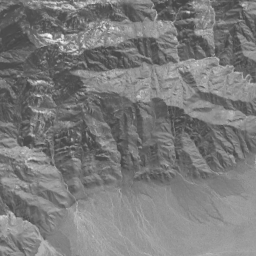

In [29]:
wgs84_transformer = Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True).transform
tile_bbox_wgs84 = transform(wgs84_transformer, tile_bbox_geom)
west, south, east, north = tile_bbox_wgs84.bounds
bounds = [[south, west], [north, east]]
folium.raster_layers.ImageOverlay(
    image=wmts_tile.data,
    bounds=bounds,
    colormap=lambda x: (x, x, x, 1),
    origin="lower"
).add_to(m)
m.fit_bounds(bounds)
m